# Predicting California’s Groundwater Levels Using Machine Learning for Sustainable Management

In [113]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.impute import SimpleImputer


## Fetching the Groundwater Level Measurements via the CA Dept. of Water Resources API

In [114]:
# Fetch data from API
def fetch_groundwater_data():
    sql_query = "SELECT * FROM \"231ba173-392a-4f62-91fb-07f4a90746d1\" WHERE county_name = 'Fresno'"
    url = f"https://data.ca.gov/api/3/action/datastore_search_sql?sql={sql_query}"

    response = requests.get(url)
    
    # Check if request was successful
    if response.status_code == 200:
        data = response.json()
        records = data['result']['records']
        df = pd.DataFrame(records)
        
        # Print basic details
        print("\nData Successfully Fetched!")
        print(f"Total Records Retrieved: {len(df)}")
        print("\nPreview of Data:\n", df.head())  # Print first few rows
        
        return df
    else:
        print("Failed to fetch data. Status Code:", response.status_code)
        return None

# Call function and print results
df = fetch_groundwater_data()

# Optional: Display full column names to understand the dataset better
if df is not None:
    print("\nColumns in DataFrame:\n", df.columns.tolist())


print(f"Total Number of Rows in Dataset: {df.shape[0]}")



Data Successfully Fetched!
Total Records Retrieved: 50000

Preview of Data:
        _id                                         _full_text  \
0  1908356  '-022.07':24 '-05':4 '-10':3 '00':5,6,7 '114.5...   
1  1810431  '-01':3 '-022.08':24 '-29':4 '00':5,6,7 '175.8...   
2  1908355  '-01':3 '-022.07':24 '-26':4 '00':5,6,7 '120.3...   
3  1810190  '-01':4 '-02':3 '-022.08':24 '00':5,6,7 '1983'...   
4  1810191  '-01':4 '-022.08':24 '-10':3 '00':5,6,7 '1982'...   

            site_code            msmt_date  wlm_rpe  wlm_gse      gwe gse_gwe  \
0  367710N1203371W001  1993-10-05T00:00:00  164.410  163.410  114.510  48.900   
1  366343N1198621W001  1990-01-29T00:00:00  252.090  252.090  175.890  76.200   
2  367710N1203371W001  1994-01-26T00:00:00  164.410  163.410  120.310  43.100   
3  366341N1197904W001  1983-02-01T00:00:00  275.690  275.690  231.090  44.600   
4  366341N1197904W001  1982-10-01T00:00:00  275.690  275.690  231.290  44.400   

  wlm_qa_desc wlm_qa_detail wlm_mthd_desc wl

## Fetch and Focus on Fresno County data for better accuracy and less variability

In [115]:
# Call function and get DataFrame
df_fresno = fetch_groundwater_data()

# Save to CSV (optional)
if df_fresno is not None:
    save_csv = True  # Set to False if you don't want to save
    if save_csv:
        df_fresno.to_csv("fresno_groundwater.csv", index=False)
        print("\Fresno County data saved as 'fresno_groundwater.csv'")


Data Successfully Fetched!
Total Records Retrieved: 50000

Preview of Data:
        _id                                         _full_text  \
0  1908355  '-01':3 '-022.07':24 '-26':4 '00':5,6,7 '120.3...   
1  1810190  '-01':4 '-02':3 '-022.08':24 '00':5,6,7 '1983'...   
2  1810191  '-01':4 '-022.08':24 '-10':3 '00':5,6,7 '1982'...   
3  1810192  '-01':4 '-02':3 '-022.08':24 '00':5,6,7 '1982'...   
4  1810193  '-022.08':24 '-10':3 '-20':4 '00':5,6,7 '1981'...   

            site_code            msmt_date  wlm_rpe  wlm_gse      gwe gse_gwe  \
0  367710N1203371W001  1994-01-26T00:00:00  164.410  163.410  120.310  43.100   
1  366341N1197904W001  1983-02-01T00:00:00  275.690  275.690  231.090  44.600   
2  366341N1197904W001  1982-10-01T00:00:00  275.690  275.690  231.290  44.400   
3  366341N1197904W001  1982-02-01T00:00:00  275.690  275.690  227.490  48.200   
4  366341N1197904W001  1981-10-20T00:00:00  275.690  275.690  227.890  47.800   

  wlm_qa_desc wlm_qa_detail wlm_mthd_desc wl

## Missing Values Analysis

/var/folders/z2/ns_w84j13gdbd48gnvk2np5c0000gn/T/ipykernel_65124/4281829942.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")


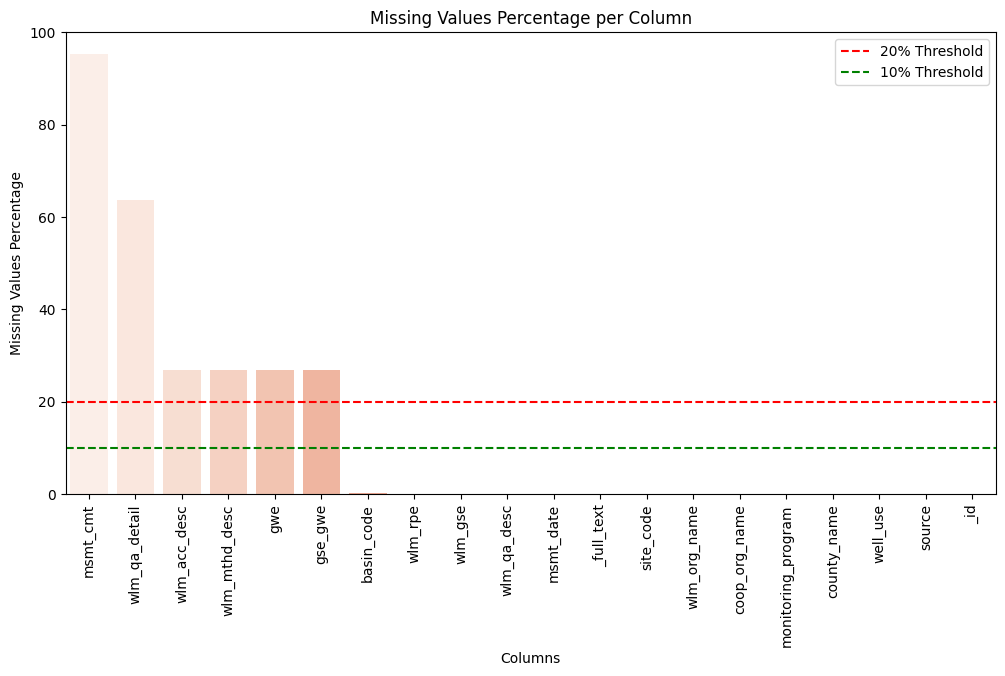

In [116]:
# Load the dataset
file_path = "./fresno_groundwater.csv"

# Read the dataset
df = pd.read_csv(file_path)

# Calculate missing values percentage per column
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Create a DataFrame for visualization
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Percentage': missing_percentage
}).sort_values(by="Missing Percentage", ascending=False)

# Plot the missing values
plt.figure(figsize=(12, 6))
sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")
plt.xticks(rotation=90)
plt.axhline(y=20, color='red', linestyle='--', label='20% Threshold')
plt.axhline(y=10, color='green', linestyle='--', label='10% Threshold')
plt.ylabel("Missing Values Percentage")
plt.xlabel("Columns")
plt.title("Missing Values Percentage per Column")
plt.legend()
plt.show()



## Cleaning the data

/var/folders/z2/ns_w84j13gdbd48gnvk2np5c0000gn/T/ipykernel_65124/1533608455.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")


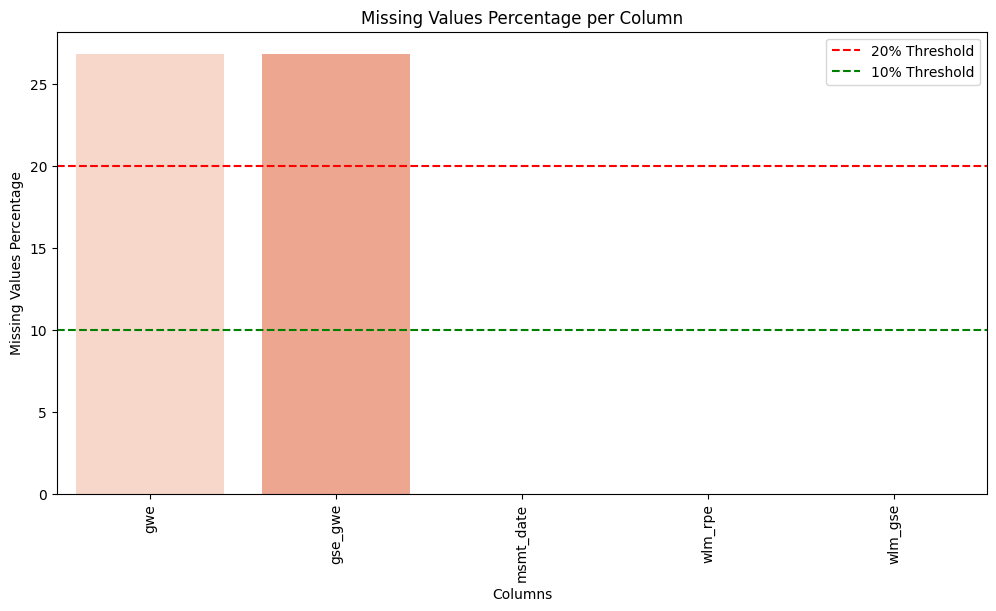

Cleaned dataset saved as 'cleaned_dataset.csv'
              Column  Missing Percentage
gwe              gwe               26.86
gse_gwe      gse_gwe               26.86
msmt_date  msmt_date                0.00
wlm_rpe      wlm_rpe                0.00
wlm_gse      wlm_gse                0.00


In [117]:
# Drop unnecessary columns
columns_to_remove = ["msmt_cmt", "wlm_qa_detail", "wlm_org_name", "coop_org_name", "monitoring_program", "county_name", "source", "well_use", "_id", "_full_text", "site_code", "wlm_qa_desc", "wlm_mthd_desc", "wlm_acc_desc", "basin_code"]
df_cleaned = df.drop(columns=[col for col in columns_to_remove if col in df.columns], errors='ignore')

# Remove columns that contain only zeros and are text-based columns like descriptions, IDs, etc.
df_cleaned = df_cleaned.loc[:, (df_cleaned != 0).any(axis=0)]

# Calculate missing values percentage per column
missing_values = df_cleaned.isnull().sum()
missing_percentage = (missing_values / len(df_cleaned)) * 100

# Create a DataFrame for visualization
missing_df = pd.DataFrame({
    'Column': df_cleaned.columns,
    'Missing Percentage': missing_percentage
}).sort_values(by="Missing Percentage", ascending=False)

# Plot the missing values
plt.figure(figsize=(12, 6))
sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")
plt.xticks(rotation=90)
plt.axhline(y=20, color='red', linestyle='--', label='20% Threshold')
plt.axhline(y=10, color='green', linestyle='--', label='10% Threshold')
plt.ylabel("Missing Values Percentage")
plt.xlabel("Columns")
plt.title("Missing Values Percentage per Column")
plt.legend()
plt.show()

# Save the cleaned dataset (optional)
df_cleaned.to_csv("cleaned_dataset.csv", index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'")

# Display missing values analysis
print(missing_df)

## Function to plot the data per type of variables

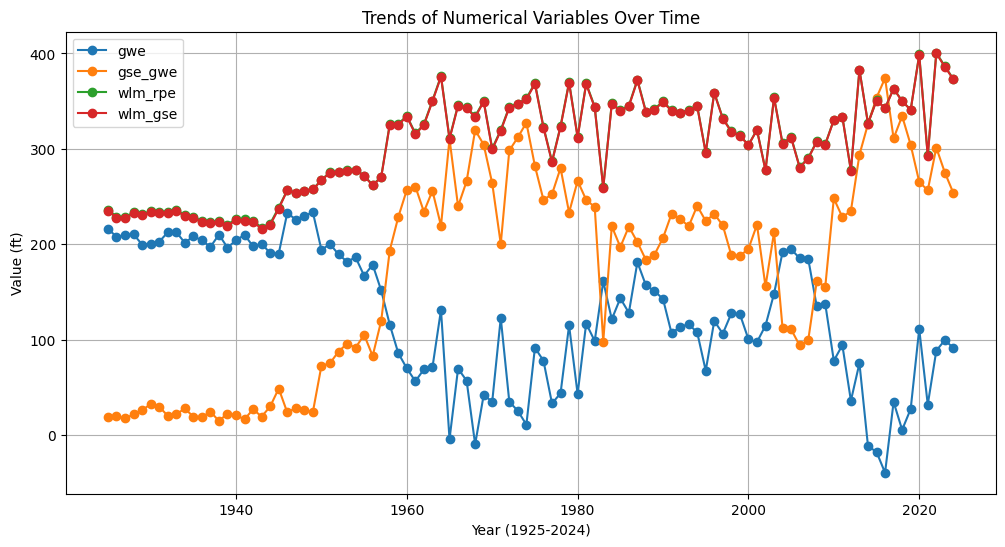

In [118]:
def plot_numerical_trends(df, variables, date_column="msmt_date"):
    # Ensure date column is in datetime format
    if date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        df["year"] = df[date_column].dt.year  # Extract year
    else:
        print(f"Date column '{date_column}' not found.")
        return
    
    # Keep only numerical columns from the provided variable list
    numeric_vars = [var for var in variables if var in df.columns and pd.api.types.is_numeric_dtype(df[var])]
    
    if not numeric_vars:
        print("No numerical variables found for plotting.")
        return

    # Create a line plot for each numerical variable over the years
    plt.figure(figsize=(12, 6))
    for var in numeric_vars:
        yearly_avg = df.groupby("year")[var].mean()  # Aggregate by year
        plt.plot(yearly_avg.index, yearly_avg.values, marker="o", label=var)

    plt.xlabel("Year (1925-2024)")
    plt.ylabel("Value (ft)")
    plt.title("Trends of Numerical Variables Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the variables to analyze
variables = [
    "wlm_mthd_desc", "wlm_acc_desc", "gwe", "gse_gwe", "msmt_date", "wlm_rpe", "wlm_gse", "wlm_qa_desc"
]

# Load your dataset
file_path = "cleaned_dataset.csv" 
df = pd.read_csv(file_path)

# Call the function
plot_numerical_trends(df, variables)



## Resample Dataframe to work with monthly value

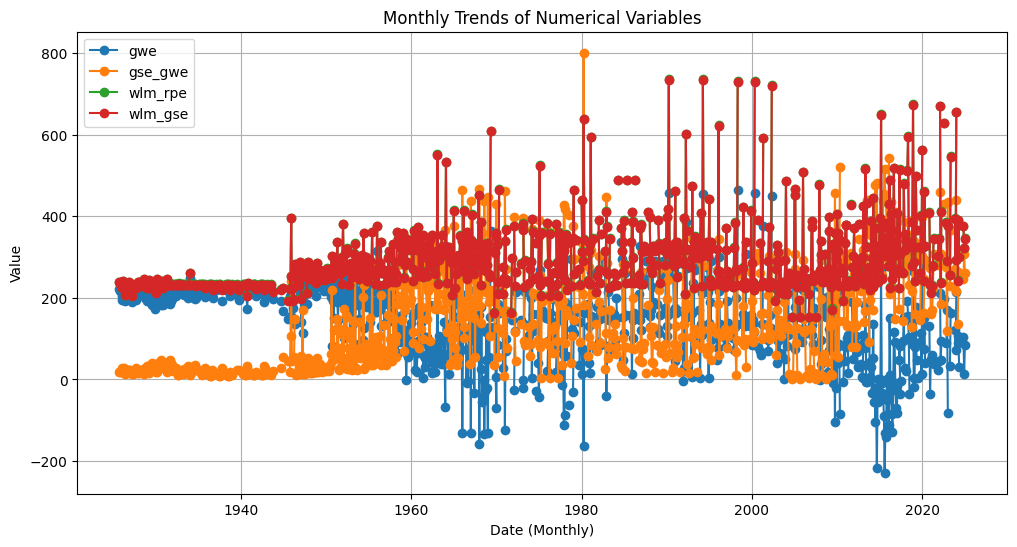

In [119]:
def plot_monthly_trends(df, variables, date_column="msmt_date"):
    # Ensure date column is in datetime format
    if date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        df.set_index(date_column, inplace=True)  # Set date as index
    else:
        print(f"Date column '{date_column}' not found.")
        return
    
    # Keep only numerical columns from the provided variable list
    numeric_vars = [var for var in variables if var in df.columns and pd.api.types.is_numeric_dtype(df[var])]
    
    if not numeric_vars:
        print("No numerical variables found for plotting.")
        return

    # Resample data by month and compute mean values
    df_resampled = df[numeric_vars].resample('M').mean()

    # Plot monthly trends
    plt.figure(figsize=(12, 6))
    for var in numeric_vars:
        plt.plot(df_resampled.index, df_resampled[var], marker="o", label=var)

    plt.xlabel("Date (Monthly)")
    plt.ylabel("Value")
    plt.title("Monthly Trends of Numerical Variables")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the variables to analyze
variables = [
    "wlm_mthd_desc", "wlm_acc_desc", "gwe", "gse_gwe", "msmt_date", "wlm_rpe", "wlm_gse", "wlm_qa_desc"
]

# Load your dataset
file_path = "cleaned_dataset.csv"  # Replace with actual file path
df = pd.read_csv(file_path)

# Call the function
plot_monthly_trends(df, variables)


## Feature Engineering

### Time-Based Feature (Extract from msmt_date)

In [148]:
# Standardize column names (remove spaces and convert to lowercase)
df_cleaned.columns = df_cleaned.columns.str.strip().str.lower()

# Check if 'msmt_date' exists (for debugging)
print("Columns in cleaned dataset:", df_cleaned.columns.tolist())

# Convert 'msmt_date' to datetime if available
if 'msmt_date' in df_cleaned.columns:
    df_cleaned['msmt_date'] = pd.to_datetime(df_cleaned['msmt_date'], errors='coerce')
    df_cleaned['year'] = df_cleaned['msmt_date'].dt.year
    df_cleaned['month'] = df_cleaned['msmt_date'].dt.month
    print("Successfully processed 'msmt_date'.")
else:
    print("'msmt_date' not found in cleaned dataset!")


Columns in cleaned dataset: ['msmt_date', 'year', 'month']
Successfully processed 'msmt_date'.


X_train = X_train.select_dtypes(include=[np.number])  # Keep only numeric columns
X_test = X_test.select_dtypes(include=[np.number])


### Water Depth & Elevation Features

df['water_table_depth'] = df['gse_gwe']
df['rolling_mean_gwe_3'] = df['gwe'].rolling(window=3).mean()
df['rolling_mean_gwe_6'] = df['gwe'].rolling(window=6).mean()


### Data Cleaning & Transformation

scaler = MinMaxScaler()
df[['gwe', 'water_table_depth']] = scaler.fit_transform(df[['gwe', 'water_table_depth']])

## Machine Learning

### Split into training and test data set

In [121]:
print(df.columns)  # Ensure 'msmt_date' exists
print(df.index.name)  # Should print 'msmt_date' if it's set as the index


df.reset_index(inplace=True)  # Moves 'msmt_date' from index to a regular column
print(df.columns)  # Now 'msmt_date' should appear in columns


Index(['wlm_rpe', 'wlm_gse', 'gwe', 'gse_gwe'], dtype='object')
msmt_date
Index(['msmt_date', 'wlm_rpe', 'wlm_gse', 'gwe', 'gse_gwe'], dtype='object')


In [122]:

# Convert msmt_date to datetime and set as index
df['msmt_date'] = pd.to_datetime(df['msmt_date'], errors='coerce')
df.set_index('msmt_date', inplace=True)

# Split the dataframe into training (2005-2016) and testing (2017+)
df_train = df[(df.index >= '1925-01-01') & (df.index < '2010-01-01')]
df_test = df[df.index >= '2017-01-01']

# Print dataset shape details
print("Shape of Training Data:", df_train.shape)
print("Shape of Testing Data:", df_test.shape)
print("Training Data Contains {:.2f}% of the Total Data".format((df_train.shape[0] * 100) / df.shape[0]))


Shape of Training Data: (37511, 4)
Shape of Testing Data: (5916, 4)
Training Data Contains 75.02% of the Total Data


In [123]:
# Define the target variable (groundwater level in future)
target_variable = 'gse_gwe'  # Predicting groundwater elevation

# Define features (predictors)
feature_variables = ['gwe', 'wlm_rpe', 'wlm_gse']  # Use relevant numerical features

# Split features (X) and target variable (y) for training
X_train = df_train[feature_variables]
y_train = df_train[target_variable].values

X_test = df_test[feature_variables]
y_test = df_test[target_variable].values

# Ensure only numeric columns are selected
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Print dataset shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (37511, 3)
X_test shape: (5916, 3)
y_train shape: (37511,)
y_test shape: (5916,)


In [124]:
print("Missing values in X_train before scaling:")
print(pd.DataFrame(X_train).isnull().sum().sort_values(ascending=False))

print("\nMissing values in X_test before scaling:")
print(pd.DataFrame(X_test).isnull().sum().sort_values(ascending=False))


Missing values in X_train before scaling:
gwe        9461
wlm_rpe       0
wlm_gse       0
dtype: int64

Missing values in X_test before scaling:
gwe        1643
wlm_rpe       0
wlm_gse       0
dtype: int64


In [125]:
print("X_train shape:", X_train.shape)
print("X_train columns:", X_train.columns.tolist())  # Check available features
print("Missing values in X_train:", X_train.isnull().sum().sum())  # Total NaN count


X_train shape: (37511, 3)
X_train columns: ['gwe', 'wlm_rpe', 'wlm_gse']
Missing values in X_train: 9461


In [126]:
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])


### Handling missing values and Scaling the data

In [127]:
from sklearn.impute import SimpleImputer

# Use mean imputation (change to "median" if necessary)
imputer = SimpleImputer(strategy="mean")  

# Apply to X_train and X_test
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Verify missing values are removed
print("Missing values after imputation:", X_train.isnull().sum().sum(), X_test.isnull().sum().sum())


Missing values after imputation: 0 0


### Scaling the data

In [128]:
# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling successful! No NaNs should remain.")

Scaling successful! No NaNs should remain.


In [129]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


print("X_train columns:", X_train.columns.tolist())  # Check available features
print("Missing values in X_train:", X_train.isnull().sum().sum())  # Total NaN count

X_train = X_train.dropna()
X_test = X_test.dropna()



X_train shape: (37511, 3)
y_train shape: (37511,)
X_test shape: (5916, 3)
y_test shape: (5916,)
X_train columns: ['gwe', 'wlm_rpe', 'wlm_gse']
Missing values in X_train: 0


In [130]:
df = df.dropna()
df.to_csv("cleaned_dataset.csv", index=False)


In [131]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train length:", len(y_train))

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test length:", len(y_test))


X_train shape: (37511, 3)
y_train shape: (37511,)
X_train_scaled shape: (37511, 3)
y_train length: 37511
X_test shape: (5916, 3)
y_test shape: (5916,)
X_test_scaled shape: (5916, 3)
y_test length: 5916


In [132]:
# Check for NaNs
print("Missing values in X_train before fixing:", X_train.isnull().sum().sum())

# Impute missing values instead of dropping rows
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")  # Use "median" if data is skewed
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Check if lengths match
print("X_train shape after imputation:", X_train.shape)
print("y_train shape after imputation:", y_train.shape)


Missing values in X_train before fixing: 0
X_train shape after imputation: (37511, 3)
y_train shape after imputation: (37511,)


In [133]:
# Ensure y_train and X_train are properly aligned
X_train, y_train = X_train.align(pd.Series(y_train), join="inner", axis=0)
X_test, y_test = X_test.align(pd.Series(y_test), join="inner", axis=0)

# Confirm equal sizes
print("Final X_train shape:", X_train.shape)
print("Final y_train shape:", y_train.shape)


Final X_train shape: (37511, 3)
Final y_train shape: (37511,)


## Training the models

In [134]:
# Re-import necessary libraries due to execution state reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to calculate performance metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    return {"Model": model_name, "MAE": mae, "MSE": mse, "RMSE": rmse}

# Load dataset (Ensure it is scaled)
file_path = "cleaned_dataset.csv"  # Adjusted file path
df = pd.read_csv(file_path)

# Convert date column to datetime and set as index
#df['msmt_date'] = pd.to_datetime(df['msmt_date'], errors='coerce')
#df.set_index('msmt_date', inplace=True)

# Define features and target
target = "gwe"  # Change if necessary
feature_columns = [col for col in df.columns if col != target] 

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df[target], test_size=0.2, random_state=42, shuffle=False)

# Apply scaling only after alignment
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Store results
results = []

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_rf, "Random Forest"))

# Train XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_xgb, "XGBoost"))

# Train Gradient Boosting (LightGBM)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_gb, "Gradient Boosting"))

# Reshape data for deep learning models (CNN & LSTM need 3D input)
X_train_dl = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_dl = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Train CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train_dl, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_cnn = cnn_model.predict(X_test_dl).flatten()
results.append(evaluate_model(y_test, y_pred_cnn, "CNN"))

# Train LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_dl.shape[1], 1)),
    LSTM(32),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_dl, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_dl).flatten()
results.append(evaluate_model(y_test, y_pred_lstm, "LSTM"))

# Convert results list to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)



229/229 [==============================] - 1s 711us/step
               Model        MAE          MSE       RMSE
0      Random Forest   1.554602     8.743724   2.956979
1            XGBoost   3.453697    38.467161   6.202190
2  Gradient Boosting   5.550587    59.829509   7.734954
3                CNN   0.364041     0.364162   0.603458
4               LSTM  12.836944  1278.799706  35.760309


## Hyperparameter tuning to achieve the lowest possible MAE, MSE, and RMSE

### Optimize Random Forest
Increase the number of estimators.

Tune max_depth and min_samples_split to prevent overfitting.

In [135]:
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    "n_estimators": [100, 200, 500],  # More trees generally improve performance
    "max_depth": [10, 20, None],  # Allow deeper trees
    "min_samples_split": [2, 5, 10],  # Control overfitting
    "min_samples_leaf": [1, 2, 4]  # Minimum samples per leaf
}

rf = RandomForestRegressor(random_state=42)
rf_grid = RandomizedSearchCV(rf, rf_params, cv=3, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

# Train with best parameters
rf_best = rf_grid.best_estimator_
y_pred_rf_best = rf_best.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_rf_best, "Random Forest (Tuned)"))


### Optimize XGBoost
Tune learning_rate for better convergence.

Adjust n_estimators and max_depth.

In [136]:
xgb_params = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
xgb_grid = RandomizedSearchCV(xgb, xgb_params, cv=3, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)

# Train with best parameters
xgb_best = xgb_grid.best_estimator_
y_pred_xgb_best = xgb_best.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_xgb_best, "XGBoost (Tuned)"))


### Optimize Gradient Boosting
Adjust n_estimators and max_depth.

Tune learning_rate for better gradient updates.

In [137]:
gb_params = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

gb = GradientBoostingRegressor(random_state=42)
gb_grid = RandomizedSearchCV(gb, gb_params, cv=3, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1)
gb_grid.fit(X_train_scaled, y_train)

# Train with best parameters
gb_best = gb_grid.best_estimator_
y_pred_gb_best = gb_best.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_gb_best, "Gradient Boosting (Tuned)"))


### Fine-tune CNN
Increase filters and kernel sizes.

Adjust batch size and epochs.

Use dropout layers to prevent overfitting

In [138]:
from tensorflow.keras.layers import Dropout

cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_dl.shape[1], 1)),  # Changed kernel_size=2
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=1, activation='relu'),  # Changed kernel_size=1
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
cnn_model.fit(X_train_dl, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(X_test_dl, y_test))

y_pred_cnn_best = cnn_model.predict(X_test_dl).flatten()
results.append(evaluate_model(y_test, y_pred_cnn_best, "CNN (Tuned)"))


Epoch 1/50
458/458 [==============================] - 1s 1ms/step - loss: 6235.4658 - val_loss: 82.7327
Epoch 2/50
458/458 [==============================] - 1s 1ms/step - loss: 487.7083 - val_loss: 51.7643
Epoch 3/50
458/458 [==============================] - 1s 1ms/step - loss: 360.3556 - val_loss: 17.5764
Epoch 4/50
458/458 [==============================] - 1s 1ms/step - loss: 307.7349 - val_loss: 10.9689
Epoch 5/50
458/458 [==============================] - 1s 1ms/step - loss: 278.8698 - val_loss: 11.4167
Epoch 6/50
458/458 [==============================] - 1s 1ms/step - loss: 259.9627 - val_loss: 5.8980
Epoch 7/50
458/458 [==============================] - 1s 1ms/step - loss: 247.8813 - val_loss: 4.4599
Epoch 8/50
458/458 [==============================] - 1s 1ms/step - loss: 241.1258 - val_loss: 14.1092
Epoch 9/50
458/458 [==============================] - 1s 1ms/step - loss: 236.2424 - val_loss: 11.8546
Epoch 10/50
458/458 [==============================] - 1s 1ms/step - loss:

### Fine-Tune LSTM
Increase the number of LSTM layers.

Use return_sequences=True for stacking.

Use dropout layers to prevent overfitting.

In [139]:
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_dl.shape[1], 1)),
    Dropout(0.2),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
lstm_model.fit(X_train_dl, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(X_test_dl, y_test))

y_pred_lstm_best = lstm_model.predict(X_test_dl).flatten()
results.append(evaluate_model(y_test, y_pred_lstm_best, "LSTM (Tuned)"))


Epoch 1/50
458/458 [==============================] - 4s 6ms/step - loss: 13206.2891 - val_loss: 112.0110
Epoch 2/50
458/458 [==============================] - 2s 5ms/step - loss: 630.3594 - val_loss: 51.3824
Epoch 3/50
458/458 [==============================] - 2s 5ms/step - loss: 384.0735 - val_loss: 22.0931
Epoch 4/50
458/458 [==============================] - 2s 5ms/step - loss: 306.1754 - val_loss: 27.6769
Epoch 5/50
458/458 [==============================] - 2s 5ms/step - loss: 275.0288 - val_loss: 32.5910
Epoch 6/50
458/458 [==============================] - 2s 5ms/step - loss: 247.1371 - val_loss: 30.6284
Epoch 7/50
458/458 [==============================] - 2s 5ms/step - loss: 228.6098 - val_loss: 18.1314
Epoch 8/50
458/458 [==============================] - 3s 6ms/step - loss: 219.0479 - val_loss: 13.8125
Epoch 9/50
458/458 [==============================] - 3s 6ms/step - loss: 211.2786 - val_loss: 7.6824
Epoch 10/50
458/458 [==============================] - 2s 5ms/step - lo

### Final Comparison

In [140]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="MAE"))


                       Model        MAE          MSE       RMSE
3                        CNN   0.364041     0.364162   0.603458
0              Random Forest   1.554602     8.743724   2.956979
5      Random Forest (Tuned)   1.554602     8.743724   2.956979
7  Gradient Boosting (Tuned)   2.118032     9.880186   3.143276
9               LSTM (Tuned)   3.328291    15.113219   3.887572
1                    XGBoost   3.453697    38.467161   6.202190
6            XGBoost (Tuned)   3.793675    36.347795   6.028913
8                CNN (Tuned)   4.737942    34.884944   5.906348
2          Gradient Boosting   5.550587    59.829509   7.734954
4                       LSTM  12.836944  1278.799706  35.760309


## Multi-step Forecasting

In [141]:
def create_multistep_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):  # Ensure within bounds
        Xs.append(X[i : i + time_steps])
        ys.append(y.iloc[i + time_steps])  # Use .iloc[] to avoid KeyError
    return np.array(Xs), np.array(ys)


# Reset y_train and y_test indices
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Create dataset for multi-step forecasting
X_train_seq, y_train_seq = create_multistep_sequences(X_train_scaled, y_train)
X_test_seq, y_test_seq = create_multistep_sequences(X_test_scaled, y_test)

# Train the model for multi-step forecasting
rf_multistep = RandomForestRegressor(n_estimators=200, random_state=42)
rf_multistep.fit(X_train_seq.reshape(X_train_seq.shape[0], -1), y_train_seq)

# Predict for the next 10 years
future_predictions = rf_multistep.predict(X_test_seq.reshape(X_test_seq.shape[0], -1))



   Actual GWE  Predicted GWE
0        37.9      20.351295
1        25.9      30.354310
2        39.0      25.462215
3        45.0      37.475725
4        33.0      43.269795
Predictions saved as 'groundwater_predictions.csv'


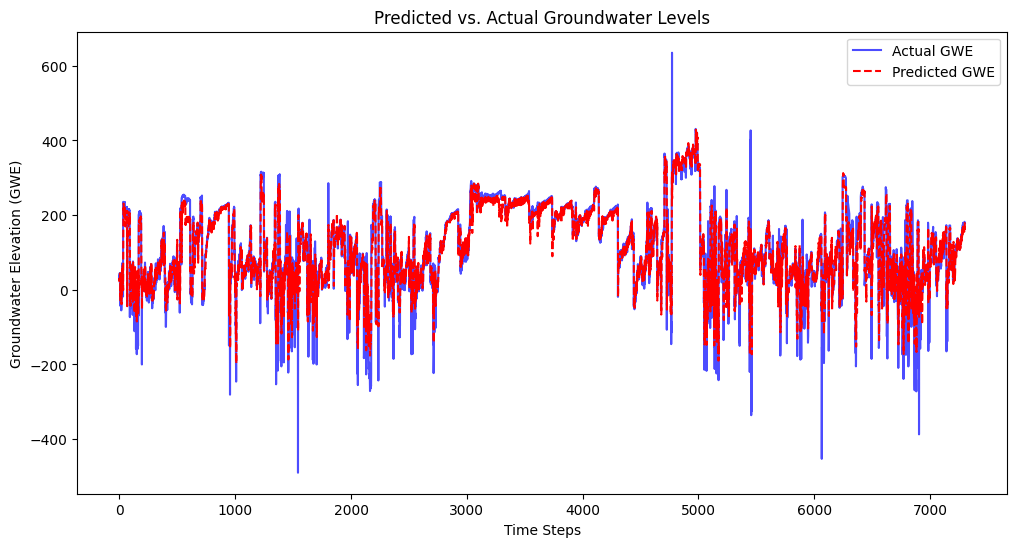

In [142]:
# Convert predictions to a DataFrame for better readability
results_df = pd.DataFrame({
    "Actual GWE": y_test_seq.flatten(),
    "Predicted GWE": future_predictions.flatten()
})

# Display first few results
print(results_df.head())



results_df.to_csv("groundwater_predictions.csv", index=False)
print("Predictions saved as 'groundwater_predictions.csv'")


import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(results_df["Actual GWE"], label="Actual GWE", color="blue", alpha=0.7)
plt.plot(results_df["Predicted GWE"], label="Predicted GWE", color="red", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Groundwater Elevation (GWE)")
plt.title("Predicted vs. Actual Groundwater Levels")
plt.legend()
plt.show()



## Implementing Future Predictions with RFC

print("Length of future_dates:", len(future_dates))
print("Length of future_predictions:", len(future_predictions))


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Ensure dataset's index is in datetime format
df.index = pd.to_datetime(df.index, errors="coerce")

# Define future prediction steps (10 years = 120 months)
future_steps = 120
last_date = pd.Timestamp("2024-12-01")  # Latest known date in dataset
future_dates = [last_date + DateOffset(months=i) for i in range(1, future_steps + 1)]

# ✅ Define the Latest Known Data
latest_manual_row = {
    "wlm_rpe": 263.443,
    "wlm_gse": 261.056,
    "gse_gwe": 19.613  # 🔹 Only use the features present in X_train
}

# Convert to DataFrame and Align Columns with Training Data
latest_features = pd.DataFrame([latest_manual_row])
latest_features = latest_features.reindex(columns=X_train.columns, fill_value=0)  # Ensure correct feature order

# ✅ Debugging: Check Feature Alignment
print("X_train shape before training:", X_train.shape)  # Expect (n_samples, 3)
print("Latest features shape before scaling:", latest_features.shape)  # Expect (1, 3)

# ✅ Scale the input using the same scaler as training
latest_features_scaled = scaler.transform(latest_features)
print("Latest features after scaling:", latest_features_scaled.shape)  # Expect (1, 3)

# ✅ Train or Load the Correct Model
if 'rf_multistep' not in globals() or rf_multistep.n_features_in_ != X_train.shape[1]:
    print("⚠ Retraining RandomForestRegressor with correct feature set...")
    rf_multistep = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_multistep.fit(X_train_scaled, y_train)  # Ensure training with only 3 features
    print("✅ Model retrained with", X_train_scaled.shape[1], "features")
else:
    print("✅ Using existing trained model.")

# ✅ Forecast Future Groundwater Levels
future_predictions = []

for i in range(future_steps):
    # Predict next groundwater level
    predicted_gwe = rf_multistep.predict(latest_features_scaled.reshape(1, -1))[0]  
    future_predictions.append(predicted_gwe)

    # ✅ Shift the input features for the next prediction
    latest_features_scaled = np.roll(latest_features_scaled, -1)
    latest_features_scaled[0, -1] = predicted_gwe  # Replace last feature with new prediction
    latest_features_scaled = latest_features_scaled.reshape(1, -1)  # Ensure correct shape

    # Debugging: Print first few predictions
    if i < 5:
        print(f"Step {i+1} - Predicted GWE: {predicted_gwe}")

print("✅ Future predictions successfully generated!")
print(f"📌 Length of future_predictions: {len(future_predictions)}")

# ✅ Create a DataFrame for Future Predictions
future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted GWE": future_predictions
})
future_df.set_index("Date", inplace=True)  # Set dates as index

# ✅ Plot the Future Predictions
plt.figure(figsize=(12, 6))
plt.plot(future_df.index, future_df["Predicted GWE"], color="red", linestyle="dashed", marker="o", label="Predicted GWE")

# Formatting the plot
plt.xlabel("Future Date")
plt.ylabel("Predicted Groundwater Elevation (GWE)")
plt.title("Forecasted Groundwater Levels for the Next 10 Years")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


Look for the rainfall data as well for producing higher accracy in the model. Otherwise, it would just be predicting based on historical data thats available. Considere adding temprature of a particular place (Fresno County) to better the analyze the accuracy scores. 



